In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from itertools import product

In [60]:
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

In [61]:
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

In [62]:
test_df["Revenue"] = test_df["Revenue"].interpolate(method="linear")

In [63]:
train_time_series = train_df.groupby("Date")[["Revenue", "Units"]].sum()

In [64]:
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05  # Trả về True nếu dữ liệu có tính dừng

In [65]:
stationary_revenue = check_stationarity(train_time_series["Revenue"], "Revenue")
stationary_units = check_stationarity(train_time_series["Units"], "Units")

ADF Test for Revenue:
ADF Statistic: -2.2722, p-value: 0.1811
ADF Test for Units:
ADF Statistic: -2.6575, p-value: 0.0817


In [66]:
train_time_series["Revenue_diff"] = train_time_series["Revenue"].diff().dropna()
check_stationarity(train_time_series["Revenue_diff"], "Differenced Revenue")
train_time_series["Units_diff"] = train_time_series["Units"].diff().dropna()
check_stationarity(train_time_series["Units_diff"], "Differenced Units")

ADF Test for Differenced Revenue:
ADF Statistic: -29.4580, p-value: 0.0000
ADF Test for Differenced Units:
ADF Statistic: -27.8358, p-value: 0.0000


True

In [67]:
p = d = q = range(0, 3)
best_score, best_params = float("inf"), None
for param in product(p, d, q):
    try:
        model = ARIMA(train_time_series["Revenue"], order=param).fit()
        aic = model.aic
        if aic < best_score:
            best_score, best_params = aic, param
    except:
        continue

print(f"Best ARIMA parameters for Revenue: {best_params} with AIC {best_score}")

c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Best ARIMA parameters for Revenue: (2, 1, 2) with AIC 114951.36230085127


c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
arima_revenue = ARIMA(train_time_series["Revenue"], order=best_params).fit()
arima_units = ARIMA(train_time_series["Units"], order=(1,1,1)).fit()


c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

In [69]:
forecast_steps = len(test_df["Date"].unique())
arima_revenue_forecast = arima_revenue.forecast(steps=forecast_steps)
arima_units_forecast = arima_units.forecast(steps=forecast_steps)

c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [70]:
forecast_dates = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps+1, freq="D")[1:]

In [71]:
arima_forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "ARIMA_Revenue": arima_revenue_forecast.values,
    "ARIMA_Units": arima_units_forecast.values
})

In [72]:
print("\nARIMA Forecast Results:")
print(arima_forecast_df.head())


ARIMA Forecast Results:
        Date  ARIMA_Revenue  ARIMA_Units
0 2021-01-01  403654.731850    97.945106
1 2021-01-02  516849.178321   112.265894
2 2021-01-03  566581.987219   114.381369
3 2021-01-04  599178.434837   114.693869
4 2021-01-05  625168.865933   114.740031


In [73]:
actual_revenue = test_df.groupby("Date")["Revenue"].sum().values[:forecast_steps]
r2 = r2_score(actual_revenue, arima_revenue_forecast)
mape = mean_absolute_percentage_error(actual_revenue, arima_revenue_forecast)
rmse = np.sqrt(mean_squared_error(actual_revenue, arima_revenue_forecast))

print("\nARIMA Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")


ARIMA Model Evaluation for Revenue:
R2 Score: -0.1080
MAPE: 1.1036
RMSE: 1058267.9962


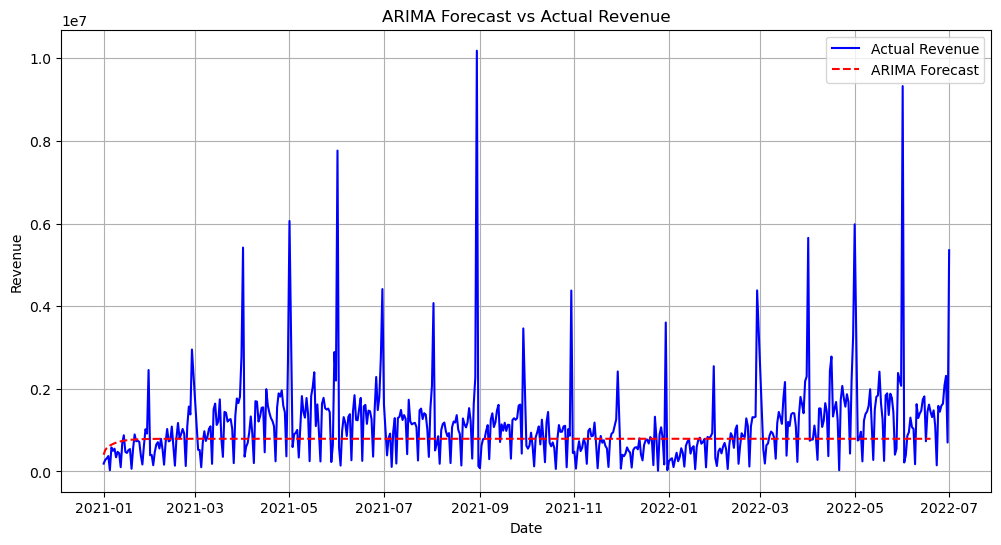

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.groupby("Date")["Revenue"].sum().index, actual_revenue, label="Actual Revenue", color='blue')
plt.plot(forecast_dates, arima_revenue_forecast, label="ARIMA Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("ARIMA Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

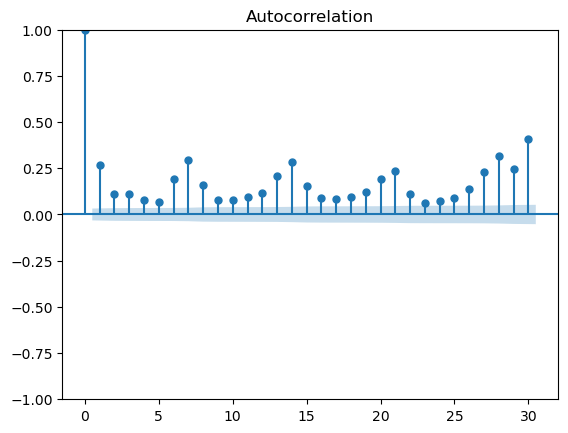

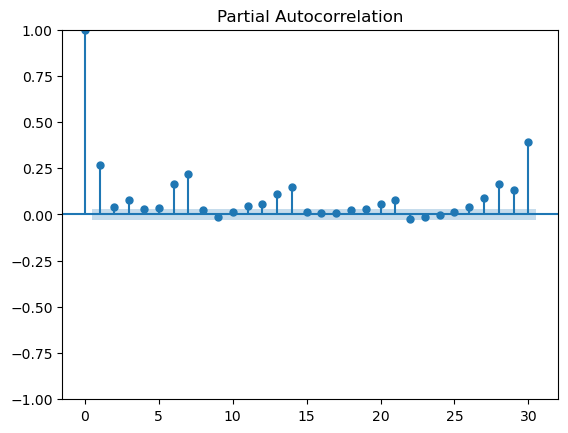

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plot_acf(train_time_series["Revenue"], lags=30)
plt.show()

plot_pacf(train_time_series["Revenue"], lags=30)
plt.show()


In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Chọn tham số SARIMA
seasonal_order = (1,1,1,12)  # s=12 cho dữ liệu theo tháng

# Huấn luyện mô hình SARIMA
sarima_model = SARIMAX(train_time_series["Revenue"], order=(1,1,1), seasonal_order=seasonal_order).fit()

# Dự báo
forecast_steps = len(test_df["Date"].unique())
sarima_forecast = sarima_model.forecast(steps=forecast_steps)

# Đánh giá mô hình
actual_revenue = test_df.groupby("Date")["Revenue"].sum().values[:forecast_steps]
r2 = r2_score(actual_revenue, sarima_forecast)
mape = mean_absolute_percentage_error(actual_revenue, sarima_forecast)
rmse = np.sqrt(mean_squared_error(actual_revenue, sarima_forecast))

print("SARIMA Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")


c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Model Evaluation for Revenue:
R2 Score: -0.4298
MAPE: 0.9139
RMSE: 1202151.6228


c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

Differencing order 0: ADF Statistic = -2.3255, p-value = 0.1639
Differencing order 1: ADF Statistic = -25.1585, p-value = 0.0000
Differencing order 0: ADF Statistic = -2.5711, p-value = 0.0991
Differencing order 1: ADF Statistic = -24.1961, p-value = 0.0000
Optimal differencing for Revenue: 1
Optimal differencing for Units: 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=112587.156, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=111467.171, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=111150.204, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=112585.157, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=111494.844, Time=0.33 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=110806.862, Time=1.49 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=110975.568, Time=0.71 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=110808.106, Time=2.45 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=110808.050, Time=2.99 sec
 ARIMA(0,1,1)(0,0

c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d


SARIMA Model Evaluation for Revenue:
R2 Score: -53276.0438
MAPE: 416.3310
RMSE: 232053899.6878

SARIMA Model Evaluation for Units:
R2 Score: -83915.7649
MAPE: 646.8366
RMSE: 36921.8474


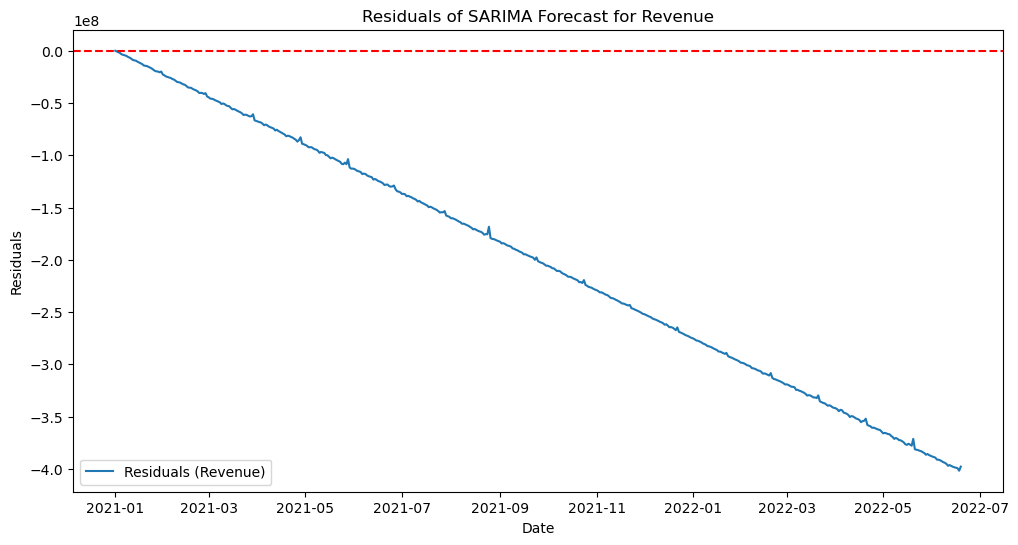

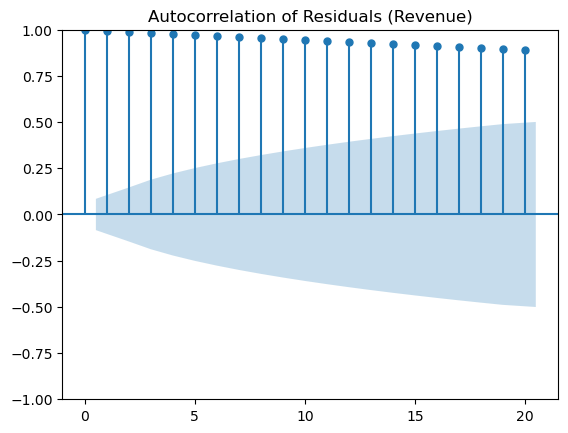

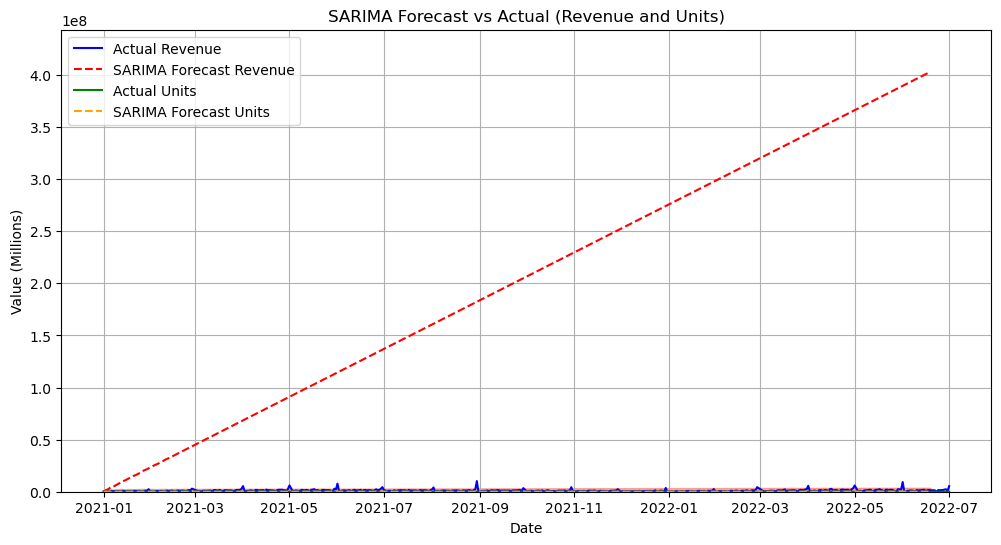

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from joblib import Parallel, delayed
from statsmodels.graphics.tsaplots import plot_acf

# Function to check stationarity and determine differencing order
def determine_differencing(series, max_d=2):
    d = 0
    current_series = series.copy()
    while d <= max_d:
        result = adfuller(current_series.dropna())
        p_value = result[1]
        print(f"Differencing order {d}: ADF Statistic = {result[0]:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:  # Stationary if p-value < 0.05
            return d
        current_series = current_series.diff().dropna()
        d += 1
    return max_d  # Return max_d if still not stationary after max_d differences

# Load and preprocess data
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Convert Date to datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Handle missing values
test_df["Revenue"] = test_df["Revenue"].interpolate(method="linear")

# Aggregate by date
train_time_series = train_df.groupby("Date")[["Revenue", "Units"]].sum()

# Outlier handling for Revenue and Units
for column in ["Revenue", "Units"]:
    Q1, Q3 = train_time_series[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    train_time_series[column] = train_time_series[column].clip(lower_bound, upper_bound)

# Determine differencing orders manually
d_revenue = determine_differencing(train_time_series["Revenue"])
d_units = determine_differencing(train_time_series["Units"])
print(f"Optimal differencing for Revenue: {d_revenue}")
print(f"Optimal differencing for Units: {d_units}")

# Use auto_arima for parameter tuning (seasonal=True assumes weekly seasonality, s=7)
from pmdarima import auto_arima

sarima_model_revenue = auto_arima(train_time_series["Revenue"], seasonal=True, m=7, d=d_revenue,
                                 start_p=0, start_q=0, max_p=3, max_q=3,
                                 start_P=0, start_Q=0, max_P=3, max_Q=3,
                                 trace=True, error_action="ignore", suppress_warnings=True)
print(sarima_model_revenue.summary())

sarima_model_units = auto_arima(train_time_series["Units"], seasonal=True, m=7, d=d_units,
                               start_p=0, start_q=0, max_p=3, max_q=3,
                               start_P=0, start_Q=0, max_P=3, max_Q=3,
                               trace=True, error_action="ignore", suppress_warnings=True)
print(sarima_model_units.summary())

# Train SARIMA models with optimal parameters
order_revenue = sarima_model_revenue.order
seasonal_order_revenue = sarima_model_revenue.seasonal_order
order_units = sarima_model_units.order
seasonal_order_units = sarima_model_units.seasonal_order

sarima_revenue = SARIMAX(train_time_series["Revenue"], order=order_revenue, seasonal_order=seasonal_order_revenue).fit()
sarima_units = SARIMAX(train_time_series["Units"], order=order_units, seasonal_order=seasonal_order_units).fit()

# Forecast
forecast_steps = len(test_df["Date"].unique())
forecast_revenue = sarima_revenue.get_forecast(steps=forecast_steps)
forecast_units = sarima_units.get_forecast(steps=forecast_steps)

forecast_revenue_mean = forecast_revenue.predicted_mean
forecast_units_mean = forecast_units.predicted_mean
conf_int_revenue = forecast_revenue.conf_int()
conf_int_units = forecast_units.conf_int()

# Generate forecast dates
forecast_dates = pd.date_range(start=train_time_series.index[-1], periods=forecast_steps + 1, freq="D")[1:]

# Reconstruct original scale if differenced
if d_revenue > 0:
    last_revenue = train_time_series["Revenue"].iloc[-1]
    forecast_revenue_mean = np.cumsum(forecast_revenue_mean) + last_revenue
    # Adjust confidence intervals if differenced
    conf_int_revenue = conf_int_revenue + last_revenue

if d_units > 0:
    last_units = train_time_series["Units"].iloc[-1]
    forecast_units_mean = np.cumsum(forecast_units_mean) + last_units
    conf_int_units = conf_int_units + last_units

# Ensure non-negative values
forecast_revenue_mean = np.clip(forecast_revenue_mean, 0, None)
forecast_units_mean = np.clip(forecast_units_mean, 0, None)

# Evaluate models
actual_revenue = test_df.groupby("Date")["Revenue"].sum().values[:forecast_steps]
actual_units = test_df.groupby("Date")["Units"].sum().values[:forecast_steps]

for name, actual, forecast in [("Revenue", actual_revenue, forecast_revenue_mean), 
                              ("Units", actual_units, forecast_units_mean)]:
    r2 = r2_score(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    print(f"\nSARIMA Model Evaluation for {name}:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.4f}")

# Residual analysis for Revenue
residuals_revenue = actual_revenue - forecast_revenue_mean
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, residuals_revenue, label="Residuals (Revenue)")
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residuals of SARIMA Forecast for Revenue")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()
plot_acf(residuals_revenue, lags=20)
plt.title("Autocorrelation of Residuals (Revenue)")
plt.show()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_df.groupby("Date")["Revenue"].sum().index, actual_revenue, label="Actual Revenue", color="blue")
plt.plot(forecast_dates, forecast_revenue_mean, label="SARIMA Forecast Revenue", color="red", linestyle="dashed")
plt.fill_between(forecast_dates, conf_int_revenue.iloc[:, 0], conf_int_revenue.iloc[:, 1], color="red", alpha=0.3)

plt.plot(test_df.groupby("Date")["Units"].sum().index, actual_units, label="Actual Units", color="green")
plt.plot(forecast_dates, forecast_units_mean, label="SARIMA Forecast Units", color="orange", linestyle="dashed")
plt.fill_between(forecast_dates, conf_int_units.iloc[:, 0], conf_int_units.iloc[:, 1], color="orange", alpha=0.3)

plt.xlabel("Date")
plt.ylabel("Value (Millions)")
plt.title("SARIMA Forecast vs Actual (Revenue and Units)")
plt.legend()
plt.grid()
plt.ylim(0, max(actual_revenue.max(), forecast_revenue_mean.max(), actual_units.max(), forecast_units_mean.max()) * 1.1)
plt.show()